# Import useful stuff

In [1]:
# interactive plots in Jupyter, used to show plots inline in the notebook
%matplotlib inline

# The igraph library
from igraph import *

# Numpy for enhanced math array management
import numpy as np

#Usata per calcolare il logaritmo
from math import log

# statistical tools (we only use ECDF)
from statsmodels.distributions.empirical_distribution import ECDF

# Mathematical plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# use to control whether to show the entire cell output or only the last_expr (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to generate random numbers
from random import *

# to fit power law distributions
from powerlaw import *

# Parameters

In [6]:
#Select the dataset
#dataset="./facebook.ncol"
#dataset="./node.ncol"
#dataset="./dataset/socfb-wosn-friends.cut.edges        #BIGGEST
#dataset="./dataset/socfb-wosn-friends.cut.sb.43K.edges #MEDIUM
dataset="dataset/socfb-wosn-friends.cut.sb.10K.edges"
#MINOR


#Select if the dataset is directed or undirected
#direct=True
direct=False

#Select if connection-mode is weak or or strong
#This is the way to find Giant component
conn_mode="WEAK"
#conn_mode="STRONG"

# Creating and manipulating graphs
## Reading graphs from files & data frames / Writing graphs to files

In [7]:
file_graph = read(dataset, format = "ncol", directed = direct)
summary(file_graph, verbosity=1, max_rows = 25, edge_list_format = 'edgelist')

IGRAPH UN-- 10000 229693 -- 
+ attr: name (v)
+ edges (vertex names):
        edge  
[0]    5--22  
[1]    5--683 
[2]    5--821 
[3]    5--469 
[4]    5--639 
[5]    5--814 
[6]    5--1528
[7]    5--1640
[8]    5--1642
[9]    5--1643
[10]   5--1648
[11]   5--2548
[12]   5--4246
[13]   5--4503
[14]   5--4964
[15]   9--23  
[16]   9--2058
[17]   9--309 
[18]   9--2175
[19]   469--9 
[20]   639--9 
[21]   1528--9
[22]   1640--9
[23]   9--47  
[24]   9--100 


## Connected components, Giant Component & Subgraphs
### Risoluzione del punto 3) .a

In [8]:
# Check whether the graph is connected or not
if file_graph.is_connected(mode = "STRONG")==True:
    print ("The graph is STRONGLY CONNECTED. Nodes are mutally connected. All Graph is the Giant Component")
    giant_component=file_graph
elif file_graph.is_connected(mode = "WEAK")==True:
    print ("The graph is WEAKLY CONNECTED. Nodes are connected. All Graph is the Giant Component")
    giant_component=file_graph
else:
    print ("The graph is NOT CONNECTED. It is necessary to find the Giant Component")    
    # Compute the connected components in the graph
    #   - "WEAK" does not consider the direction of edges
    #All clusters
    clusters_list = file_graph.clusters(mode = conn_mode)
    # the number of clusters
    print ("Number of clusters")
    len(clusters_list)    
    # the membership of vertices in the clusters. Every pos has the cluster_ID associated to the vertex
    clusters_list.membership[0:10]
    # the sizes of the clusters
    print ("Clusters size:")
    clusters_list.sizes()[0:10]

    #Does Giant COmponent exist? 
    #GC esiste se contiene una frazione >> di nodi rispetto a logN (N =numero totale di nodi nel grafo), 
    #Gli altri componenti sono nell’ordine di logN
    
    
    # number of vertices and edges in the original graph
    file_graph.vcount()
    file_graph.ecount()
    
    #Trashold
    trashold=10*log(file_graph.vcount(),10)
    print ("Trashold is:", trashold)
    
    
    # sizes (sorted, first 20 elements)
    sorted_clusters = sorted(clusters_list.sizes(), reverse=True)[0:19]
    
    #bigger_cluster=max(clusters_list.sizes())
    print ("Bigger Cluster:", sorted_clusters[0])
    print ("2nd Bigger Cluster:", sorted_clusters[1])
    
    if sorted_clusters[0] > trashold and sorted_clusters[1] < trashold:
        print ("GIANT COMPONENT EXIST!!!")
    
        #Select the Giant Componet (the biggest cluster)
        giant_component = clusters_list.giant()
    
        # number of vertices and edges in the original graph
        giant_component.vcount() 
        giant_component.ecount()
    
        #From this time we consider GC as the only one cluster 
        file_graph=giant_component
    else :
        print ("GIANT COMPONENT DOES NOT EXIST!!!")
        exit(0)



The graph is STRONGLY CONNECTED. Nodes are mutally connected. All Graph is the Giant Component


In [9]:
    summary(giant_component, verbosity = 1, max_rows = 25, edge_list_format = "edgelist")

IGRAPH UN-- 10000 229693 -- 
+ attr: name (v)
+ edges (vertex names):
        edge  
[0]    5--22  
[1]    5--683 
[2]    5--821 
[3]    5--469 
[4]    5--639 
[5]    5--814 
[6]    5--1528
[7]    5--1640
[8]    5--1642
[9]    5--1643
[10]   5--1648
[11]   5--2548
[12]   5--4246
[13]   5--4503
[14]   5--4964
[15]   9--23  
[16]   9--2058
[17]   9--309 
[18]   9--2175
[19]   469--9 
[20]   639--9 
[21]   1528--9
[22]   1640--9
[23]   9--47  
[24]   9--100 


### Graph of major nodes (degree > 100)

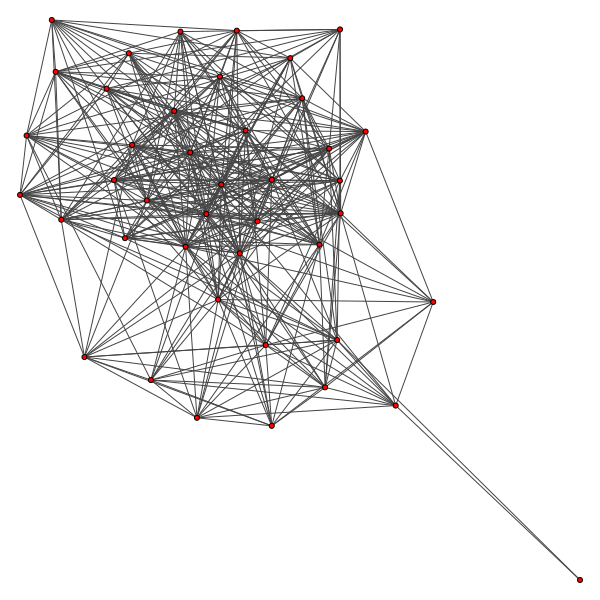

In [13]:
# Select only nodes with degree > 100 from the Giant Component
vertex_sequence = giant_component.vs.select(_degree_ge = 314)
giant_component_subgraph = giant_component.induced_subgraph(vertex_sequence)

try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}
    
visual_style["bbox"] = (600,600)
visual_style["label"] = []
visual_style["layout"] = giant_component_subgraph.layout_fruchterman_reingold()
visual_style["vertex_size"] = 5
visual_style["vertex_color"] = 'red'
visual_style["vertex_shape"] = 'circle'
visual_style["edge_arrow_size"] = 0.2
#visual_style["edge_width"] = np.array(giant_component_subgraph.es["weight"])/10

plot(giant_component_subgraph, **visual_style)

# Punto 3.b) Distrebution Degree

In [14]:
# degree() method
# - mode = "ALL" to consider the undirected graph
degree_sequnce = giant_component.degree(mode = "all")
degree_sequnce[0:19]

# the maximum degree, and the ID of the node with maximum degree
print ("maximum degree:", max(degree_sequnce))
id_max = np.argmax(degree_sequnce)
print ("ID of the node with max degree: ",id_max)

# the set of neighbours of the node with max degree
# - NB: in case of bidirectional links, the same neighbour is counted twice if mode = 'all'
neighbours_of_major_node = giant_component.neighbors(id_max, mode="all")
neighbours_of_major_node[0:19]
len(neighbour_list_of_major_node)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours_order_1 = giant_component.neighborhood(id_max, order = 1, mode="all")
neighbours_order_1[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours_order_1)
giant_component.neighborhood_size(id_max, order = 1, mode="all")

[15, 16, 14, 10, 418, 92, 23, 295, 30, 12, 8, 8, 10, 13, 23, 15, 129, 418, 6]

maximum degree: 1098
ID of the node with max degree:  492


[4, 7, 17, 26, 29, 34, 37, 38, 44, 51, 56, 57, 61, 69, 71, 72, 73, 78, 79]

NameError: name 'neighbour_list_of_major_node' is not defined

__Note__

Why is the output of $\tt{neighbourhood\_size()}$ different from the length of $\tt{nei}$?

- consider that we used a __directed__ graph, and think what does it means in terms of degree and neighbours

Let's redo the same on the equivalent __undirected__ graph

In [22]:
# take the undirected version of the Giant Component 
# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)
giant_component_undir = giant_component.as_undirected(combine_edges = "sum")

# Note the lower number of edges with respect to the directed version.
# This is because igraph automatically simplifies the graph (i.e., merges edges between the same nodes)
# to do so manually on a multi-edge graph: g.simplify()
# to check if the graph is simple or not: g.is_simple()
summary(giant_component_undir, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)

# the maximum degree, and the ID of the node with maximum degree
degree_sequence_undir = giant_component_undir.degree()
max(degree_sequence_undir)
id_max_u = np.argmax(degree_sequence_undir)
id_max_u

# the set of neighbours of the node with max degree
neighbours_of_major_node_undir = giant_component_undir.neighbors(id_max_u)
len(neighbours_of_major_node_undir)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours_order_1 = giant_component_undir.neighborhood(id_max, order = 1, mode="all")
neighbours_order_1[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours_order_1)
giant_component_undir.neighborhood_size(id_max, order = 1, mode="all")

IGRAPH UNW- 43953 262631 -- 
+ attr: name (v), weight (e)
+ edges (vertex names):
         edge     weight
[0]    2--3           13
[1]    2--79           1
[2]    2--872          1
[3]    2--1043         1
[4]    2--1847         8
[5]    2--3306        11
[6]    2--3372         3
[7]    2--4605         1
[8]    2--5402         4
[9]    2--5875         4
[10]   2--8785        16
[11]   2--10609       25
[12]   2--10998        1
[13]   2--11186        5
[14]   2--12172        3
[15]   2--17766        1
[16]   2--18086        6
[17]   2--18745        1
[18]   2--30579        5
[19]   2--42558        1
[20]   2--3            8
[21]   5--27         163
[22]   5--108          3
[23]   5--129          2
[24]   5--207          5


314

2720

314

[2720,
 7,
 28,
 221,
 228,
 317,
 359,
 459,
 701,
 819,
 1094,
 1096,
 1514,
 1613,
 1698,
 1703,
 1977,
 2264,
 2299]

224

224

### Degree density and CCDF